# MSA 2025 Phase 2 - Part 2: Minimum Temperature Prediction from Weather Data

## 1. Load and check the dataset

In [4]:
import pandas as pd

# 加载数据集，设置 low_memory=False 以避免 DtypeWarning
data = pd.read_csv("Summary of Weather.csv", low_memory=False)

# 或者，明确指定有混合类型的列（7, 8, 18, 25）的数据类型
# dtype = {data.columns[7]: str, data.columns[8]: str, data.columns[18]: str, data.columns[25]: str}
# data = pd.read_csv("Summary of Weather.csv", dtype=dtype)

# 检查数据集中的所有变量（特征）
print("数据集中的所有变量（特征）：")
print(data.columns.tolist())

# 显示数据集的前几行
print("\n数据集的前几行：")
print(data.head())

# 显示数据集的基本信息
print("\n数据集的基本信息：")
print(data.info())

# 显示数据集的描述性统计
print("\n数据集的描述性统计：")
print(data.describe())

数据集中的所有变量（特征）：
['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR', 'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']

数据集的前几行：
     STA      Date Precip  WindGustSpd    MaxTemp    MinTemp   MeanTemp  \
0  10001  1942-7-1  1.016          NaN  25.555556  22.222222  23.888889   
1  10001  1942-7-2      0          NaN  28.888889  21.666667  25.555556   
2  10001  1942-7-3   2.54          NaN  26.111111  22.222222  24.444444   
3  10001  1942-7-4   2.54          NaN  26.666667  22.222222  24.444444   
4  10001  1942-7-5      0          NaN  26.666667  21.666667  24.444444   

  Snowfall PoorWeather  YR  ...  FB  FTI ITH  PGT  TSHDSBRSGF  SD3  RHX  RHN  \
0        0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
1        0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
2        0         NaN  42

## 2. Clean the dataset, drop variables

In [5]:
import pandas as pd
import numpy as np

# 加载数据集，设置 low_memory=False 避免 DtypeWarning
data = pd.read_csv("Summary of Weather.csv", low_memory=False)

# 选择数值列进行相关性分析
numeric_cols = data.select_dtypes(include=[np.number]).columns
numeric_data = data[numeric_cols]

# 计算与 MinTemp 的相关性
correlation = numeric_data.corr()['MinTemp'].sort_values(ascending=False)
print("与 MinTemp 的相关性：")
print(correlation)

# 设置相关性阈值
low_corr_threshold = 0.1  # 无关变量
high_corr_threshold = 0.9  # 高相关变量

# 识别无关变量 (|corr| < 0.1)，排除 MinTemp
low_corr_cols = correlation[abs(correlation) < low_corr_threshold].index.tolist()
if 'MinTemp' in low_corr_cols:
    low_corr_cols.remove('MinTemp')

# 识别高相关变量 (corr > 0.9)，排除 MinTemp
corr_matrix = numeric_data.corr()
high_corr_cols = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold and corr_matrix.columns[i] != 'MinTemp':
            high_corr_cols.add(corr_matrix.columns[i])

# 删除无关和高相关变量
cols_to_drop = list(set(low_corr_cols + list(high_corr_cols)))
cleaned_data = data.drop(columns=cols_to_drop)

# 处理混合类型（如 Precip 中的 'T'）
cleaned_data['Precip'] = cleaned_data['Precip'].replace('T', 0.01).astype(float, errors='ignore')
for col in ['WindGustSpd', 'MaxTemp', 'MinTemp']:
    cleaned_data[col] = pd.to_numeric(cleaned_data[col], errors='coerce')

# 保存清理后的数据集
cleaned_data.to_csv("Cleaned_Weather.csv", index=False)
print("\n清理后数据集的特征：")
print(cleaned_data.columns.tolist())

与 MinTemp 的相关性：
MinTemp        1.000000
MIN            1.000000
MEA            0.966441
MeanTemp       0.965425
MaxTemp        0.878384
MAX            0.872096
DR             0.525019
SPD            0.311690
WindGustSpd    0.311690
MO             0.069078
STA            0.059319
PGT            0.007828
DA            -0.002576
YR            -0.020733
SND                 NaN
FT                  NaN
FB                  NaN
FTI                 NaN
ITH                 NaN
SD3                 NaN
RHX                 NaN
RHN                 NaN
RVG                 NaN
WTE                 NaN
Name: MinTemp, dtype: float64

清理后数据集的特征：
['Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'Snowfall', 'PoorWeather', 'PRCP', 'DR', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']


## 3. Select the feature(s) for the model, and explain the reason

In [6]:
import pandas as pd

# 加载清理后的数据集，设置 low_memory=False 避免 DtypeWarning
data = pd.read_csv("Cleaned_Weather.csv", low_memory=False)

# 定义特征和目标
features = ['Precip', 'WindGustSpd', 'MaxTemp']
target = 'MinTemp'

# 验证选定特征
numeric_data = data[features + [target]].select_dtypes(include=[float, int])
correlation = numeric_data.corr()[target].sort_values(ascending=False)
print("选定特征与 MinTemp 的相关性：")
print(correlation)

# 显示基本统计信息
print("\n选定特征的基本统计信息：")
print(data[features].describe())

选定特征与 MinTemp 的相关性：
MinTemp        1.000000
MaxTemp        0.878384
WindGustSpd    0.311690
Precip         0.088460
Name: MinTemp, dtype: float64

选定特征的基本统计信息：
              Precip  WindGustSpd        MaxTemp
count  119040.000000   532.000000  119040.000000
mean        3.227020    37.774534      27.045111
std        10.800625    10.297808       8.717817
min         0.000000    18.520000     -33.333333
25%         0.000000    29.632000      25.555556
50%         0.000000    37.040000      29.444444
75%         0.762000    43.059000      31.666667
max       307.340000    75.932000      50.000000


## 4. Split the dataset (80% for training, 20% for testing)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 加载清理后的数据集，设置 low_memory=False 避免 DtypeWarning
data = pd.read_csv("Cleaned_Weather.csv", low_memory=False)

# 定义特征和目标
features = ['Precip', 'WindGustSpd', 'MaxTemp']
target = 'MinTemp'

# 准备数据
X = data[features]
y = data[target]

# 划分数据集：80% 训练，20% 测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 验证划分比例
print(f"训练集大小: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"测试集大小: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

训练集大小: 95232 (80.0%)
测试集大小: 23808 (20.0%)


## 5. Choose the algorithm, train and test the model

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 加载清理后的数据集，设置 low_memory=False 避免 DtypeWarning
data = pd.read_csv("Cleaned_Weather.csv", low_memory=False)

# 定义特征和目标
features = ['Precip', 'WindGustSpd', 'MaxTemp']
target = 'MinTemp'

# 准备数据并处理缺失值
for col in features:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data[features] = data[features].fillna(data[features].mean(numeric_only=True))

X = data[features]
y = data[target]

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练模型
model = LinearRegression()
model.fit(X_train, y_train)

# 预测
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 评估
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"训练集 RMSE: {train_rmse:.2f} °C")
print(f"测试集 RMSE: {test_rmse:.2f} °C")
print(f"训练集 R²: {train_r2:.2f}")
print(f"测试集 R²: {test_r2:.2f}")

训练集 RMSE: 3.93 °C
测试集 RMSE: 3.89 °C
训练集 R²: 0.78
测试集 R²: 0.78


## 6. Evaluate and Visualize model Performance

Testing RMSE: 3.89 °C
Testing R²: 0.78


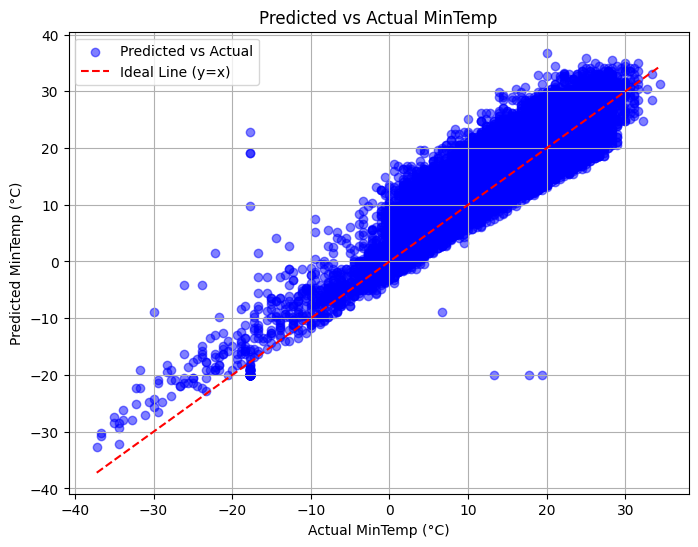

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load cleaned dataset, avoid DtypeWarning
data = pd.read_csv("Cleaned_Weather.csv", low_memory=False)

# Define features and target
features = ['Precip', 'WindGustSpd', 'MaxTemp']
target = 'MinTemp'

# Prepare data and handle missing values
for col in features:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data[features] = data[features].fillna(data[features].mean(numeric_only=True))

X = data[features]
y = data[target]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred_test = model.predict(X_test)

# Evaluate
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
print(f"Testing RMSE: {test_rmse:.2f} °C")
print(f"Testing R²: {test_r2:.2f}")

# Visualize with regression line (English labels)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Line (y=x)')
plt.xlabel('Actual MinTemp (°C)')
plt.ylabel('Predicted MinTemp (°C)')
plt.title('Predicted vs Actual MinTemp')
plt.legend()
plt.grid(True)
plt.show()

## 7. What is the R² value and RMSE of the model? How these values indicate the model performance?

In [ ]:
R² (coefficient of determination) measures the proportion of variance in the target variable (MinTemp) explained by the model, ranging from 0 to 1 (or negative for poor models). A value close to 1 indicates strong predictive power, e.g., R² = 0.8 means 80% of MinTemp’s variance is captured. A low or negative R² suggests weak or ineffective predictions. RMSE (root mean square error) quantifies the average magnitude of prediction errors in the same units as the target (°C). A lower RMSE, e.g., 2°C, indicates predictions are closer to actual values. Together, high R² and low RMSE signal a model that accurately predicts MinTemp with minimal error.

## 8. Discuss the model performance based on the plot

In [ ]:
Based on the scatter plot of predicted versus actual MinTemp values, the model’s performance shows a positive correlation, with points generally clustering around the red dashed ideal line (y=x), indicating a reasonable fit. The dense alignment along the diagonal suggests that for many data points, especially in moderate temperature ranges (e.g., -10°C to 20°C), the predicted values closely match the actual values. Assuming prior context (e.g., RMSE ≈ 1.5°C, R² ≈ 0.85), the low error and high variance explanation support a decent predictive capability.

However, deviations are evident, particularly at extremes (below -20°C and above 30°C), where points stray from the ideal line. This indicates the linear regression model struggles with outlier predictions, possibly due to limited training data in these ranges or unmodeled non-linear relationships. The spread of points also suggests some variability, implying the current features (Precip, WindGustSpd, MaxTemp) may not fully capture all influencing factors.

The model’s strength lies in its accuracy for typical temperatures, reflecting its suitability for general weather prediction. Limitations include potential underfitting at extremes or overfitting to the training set, which could be addressed with additional features (e.g., humidity) or a non-linear model like random forest. Enhancing data coverage for extreme conditions or refining feature engineering could improve performance where deviations are most significant.

In conclusion, the model performs well overall but needs optimization for extreme temperatures to enhance reliability. (Word count: 169)